In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %% [markdown]
# ## CNN LSTM
# 
# We have seen that the CNN model is capable of automatically learning and extracting features
# from the raw sequence data without scaling or dierencing. We can combine this capability
# with the LSTM where a CNN model is applied to sub-sequences of input data, the results of
# which together form a time series of extracted features that can be interpreted by an LSTM
# model. This combination of a CNN model used to read multiple subsequences over time by an
# LSTM is called a CNN-LSTM model.
# 


 Los CNN hyperparams eran:

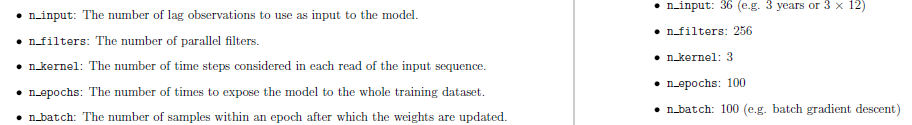

In [2]:
from IPython.display import Image
Image(".\pics\CNN_TS_hyperparams.PNG", width=3, height=5)


 Y los de LSTM:

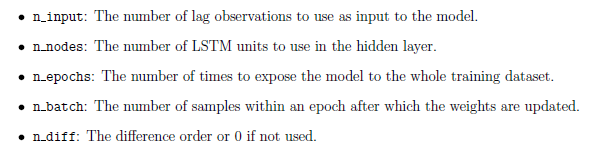

In [3]:
from IPython.display import Image
Image(".\pics\LSTM_TS_hyperparams.PNG", width=3, height=5)


 ### Y en el caso de nuestra CNN-LSTM tenemos:

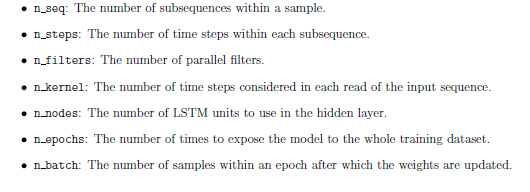

In [4]:
from IPython.display import Image
Image(".\pics\CNN_LSTM_TS_hyperparams.PNG", width=3, height=5)


 ## En este caso, tenemos:
 * dataset origen de 6 años con frecuencia mensual
 * dividimos esta serie en 4 input_seq (samples)
 * cada sample (input_seq) se compone de n_seq=2 sub-sequences
 * cada sub-sequence se compone de 12 meses


In [5]:
import tensorflow

gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tensorflow.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tensorflow.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)



1 Physical GPUs, 1 Logical GPUs


In [6]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from matplotlib import pyplot



In [7]:
#data source: https://datasetsearch.research.google.com/search?query=univariate%20time%20series&docid=Z2B66b7T3lUIl0y6AAAAAA%3D%3D&filters=bm9uZQ%3D%3D&property=aXNfYWNjZXNzaWJsZV9mb3JfZnJlZQ%3D%3D
ev_sales_data = read_csv(r'.\datasets\china_electric_vehicles_sales.csv')

ev_sales_data['Date'] = pd.to_datetime(ev_sales_data['Year/Month'])
ev_sales_data.set_index('Date', inplace=True)
ev_sales_data.drop(columns=['Year/Month'], inplace=True)

sales_series_values = ev_sales_data['sales'].values
ev_sales_data.head(5)



,BEV,sales
Date,,
2011-01-01,588,310
2011-02-01,47,417
2011-03-01,159,286
2011-04-01,173,162
2011-05-01,305,470


In [8]:
ev_sales_data['year'] = pd.Series(ev_sales_data.index).apply(lambda x: x.year).values
ev_sales_data['month'] = pd.Series(ev_sales_data.index).apply(lambda x: x.month).values
ev_sales_data.head(5)



,BEV,sales,year,month
Date,,,,
2011-01-01,588,310,2011,1
2011-02-01,47,417,2011,2
2011-03-01,159,286,2011,3
2011-04-01,173,162,2011,4
2011-05-01,305,470,2011,5


In [9]:
def make_line_plots(title, dataset, attributes_to_plot=[], x_axis_label='x', y_axis_label='y', 
                        background_color=None, legend_location="top_left", line_colors=['red'],
                        x_axis_type=None, tools = "pan,wheel_zoom,box_zoom,reset"):
        try:
            from bokeh.plotting import figure, show, output_file
            from bokeh.models import HoverTool
            from bokeh.io import output_notebook

            output_notebook()

            p = figure(title=title, x_axis_type=x_axis_type, tools=tools, background_fill_color=background_color)
            p.legend.location = legend_location

            #x_values = dataset.index
            x_values = pd.to_datetime(dataset.index)
            i = 0
            for attribute in attributes_to_plot:
                    attribute_values = dataset[attribute]
                    p.line(x_values, attribute_values, legend=attribute, line_dash=[4, 4], line_color=line_colors[i], 
                            line_width=2)
                    i += 1


            p.y_range.start = 0
            p.legend.location = legend_location
            p.legend.background_fill_color = background_color
            p.xaxis.axis_label = x_axis_label
            p.yaxis.axis_label = y_axis_label
            p.grid.grid_line_color="white"

            p.add_tools(HoverTool())
            p.select_one(HoverTool).tooltips = [
                                    (x_axis_label, '@x'),
                                    (y_axis_label, '@y'),
                                ]
                                
            p.legend.click_policy="hide"

            show(p)

        except Exception as exc:
            return exc
            #logger.exception('raised exception at {}: {}'.format(logger.name+'.'+make_line_plots.__name__, exc))



In [10]:
make_line_plots('EV monthly sales', ev_sales_data, attributes_to_plot=['sales'], x_axis_label='Month', y_axis_label='Sales', line_colors=['blue'], x_axis_type="datetime")


Loading BokehJS ...

 ### Escogemos el valor de 'sales', nuestra variable de interés, y la formateamos según el spliteo definido:

In [11]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values



In [12]:
# define config
config = [2, 12, 64, 3, 100, 200, 100]
n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
# n_input lag observations
n_input = n_seq*n_steps #-->número de valores mensuales del dataset de origen por cada input sample
# prepare data
sales_data = ev_sales_data['sales'].values
data = series_to_supervised(sales_data, n_input)
data[:4]


array([[ 310.,  417.,  286.,  162.,  470.,  273.,  650., 1323.,  688.,
         663.,  896.,  443.,  216.,  512.,  826.,  635.,  746., 1483.,
        1728., 1701., 1306., 1395., 1999., 2741.,  436.],
       [ 417.,  286.,  162.,  470.,  273.,  650., 1323.,  688.,  663.,
         896.,  443.,  216.,  512.,  826.,  635.,  746., 1483., 1728.,
        1701., 1306., 1395., 1999., 2741.,  436.,  197.],
       [ 286.,  162.,  470.,  273.,  650., 1323.,  688.,  663.,  896.,
         443.,  216.,  512.,  826.,  635.,  746., 1483., 1728., 1701.,
        1306., 1395., 1999., 2741.,  436.,  197.,  583.],
       [ 162.,  470.,  273.,  650., 1323.,  688.,  663.,  896.,  443.,
         216.,  512.,  826.,  635.,  746., 1483., 1728., 1701., 1306.,
        1395., 1999., 2741.,  436.,  197.,  583.,  546.]])

 ### cada array contiene 25 time steps mensuales, 24 de train (n_input) y 1 para predecir

In [13]:
train_x, train_y = data[:, :-1], data[:, -1]
print('train_x.shape: ', train_x.shape)
train_x[:5] # esperamos obtener 24 time steps por cada sample (o input_seq)



train_x.shape:  (36, 24)


array([[ 310.,  417.,  286.,  162.,  470.,  273.,  650., 1323.,  688.,
         663.,  896.,  443.,  216.,  512.,  826.,  635.,  746., 1483.,
        1728., 1701., 1306., 1395., 1999., 2741.],
       [ 417.,  286.,  162.,  470.,  273.,  650., 1323.,  688.,  663.,
         896.,  443.,  216.,  512.,  826.,  635.,  746., 1483., 1728.,
        1701., 1306., 1395., 1999., 2741.,  436.],
       [ 286.,  162.,  470.,  273.,  650., 1323.,  688.,  663.,  896.,
         443.,  216.,  512.,  826.,  635.,  746., 1483., 1728., 1701.,
        1306., 1395., 1999., 2741.,  436.,  197.],
       [ 162.,  470.,  273.,  650., 1323.,  688.,  663.,  896.,  443.,
         216.,  512.,  826.,  635.,  746., 1483., 1728., 1701., 1306.,
        1395., 1999., 2741.,  436.,  197.,  583.],
       [ 470.,  273.,  650., 1323.,  688.,  663.,  896.,  443.,  216.,
         512.,  826.,  635.,  746., 1483., 1728., 1701., 1306., 1395.,
        1999., 2741.,  436.,  197.,  583.,  546.]])

In [14]:
train_y[:5]  #esperamos ver 5 valores en total



array([ 436.,  197.,  583.,  546., 1517.])

In [15]:
# reshape input samples
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
print('train_x.shape: ', train_x.shape)
train_x[:1]


train_x.shape:  (36, 24, 1)


array([[[ 310.],
        [ 417.],
        [ 286.],
        [ 162.],
        [ 470.],
        [ 273.],
        [ 650.],
        [1323.],
        [ 688.],
        [ 663.],
        [ 896.],
        [ 443.],
        [ 216.],
        [ 512.],
        [ 826.],
        [ 635.],
        [ 746.],
        [1483.],
        [1728.],
        [1701.],
        [1306.],
        [1395.],
        [1999.],
        [2741.]]])

 ### The same CNN model must be applied to each input subsequence; The output of one application of the CNN submodel will be a vector. The output of the submodel to each input subsequence will be a time series of interpretations that can be interpreted by an LSTM model.

> 4618.656
 > 6426.265
 > 4288.326
 > 7754.523
 > 5593.656
 > 6223.880
 > 6510.391
 > 4305.843
 > 6314.830
 > 4747.754
 > 3664.555
 > 6724.283
 > 6799.972
 > 4405.079
 > 6619.421
 > 5498.078
 > 6964.360
 > 6418.506
 > 6749.194
 > 4623.084
 > 6707.084
 > 7052.399
 > 4076.648
 > 2317.446
 > 5448.578
 > 5228.353
 > 5159.026
 > 6181.317
 > 5350.988
 > 5272.172
cnn-lstm: 5601.489 RMSE (+/- 1199.527)


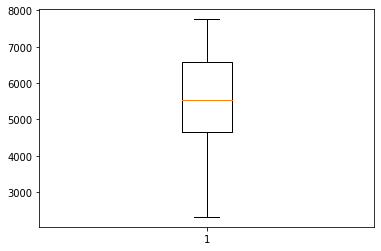

In [16]:
breakpoint()
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))
# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
        activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
        activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model
# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)

        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

n_test = 10
# grid search
scores = repeat_evaluate([tensorflow.cast(x, tensorflow.float32) for x in sales_series_values], config, n_test)
# summarize scores
summarize_scores('cnn-lstm', scores)


## Ahora paso a paso:

In [17]:
sales_series_values


array([  310,   417,   286,   162,   470,   273,   650,  1323,   688,
         663,   896,   443,   216,   512,   826,   635,   746,  1483,
        1728,  1701,  1306,  1395,  1999,  2741,   436,   197,   583,
         546,  1517,   488,   123,    80,    52,     1,    58,  1373,
         523,   387,  1589,  1136,  1767,  1037,  1709,  2460,  4358,
        3160,  4346,  6897,  3148,  6334,  4079,  5730,  6354,  8308,
        7338, 12085, 12736, 11384, 11402, 16225], dtype=int64)

In [20]:
train, test = train_test_split(sales_series_values, n_test)


In [21]:
train

array([ 310,  417,  286,  162,  470,  273,  650, 1323,  688,  663,  896,
        443,  216,  512,  826,  635,  746, 1483, 1728, 1701, 1306, 1395,
       1999, 2741,  436,  197,  583,  546, 1517,  488,  123,   80,   52,
          1,   58, 1373,  523,  387, 1589, 1136, 1767, 1037, 1709, 2460,
       4358, 3160, 4346, 6897, 3148, 6334], dtype=int64)

In [22]:
test

array([ 4079,  5730,  6354,  8308,  7338, 12085, 12736, 11384, 11402,
       16225], dtype=int64)

In [24]:
n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
n_input = n_seq * n_steps
# prepare data
data = series_to_supervised(train, n_input)
data

array([[3.100e+02, 4.170e+02, 2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02,
        6.500e+02, 1.323e+03, 6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02,
        2.160e+02, 5.120e+02, 8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03,
        1.728e+03, 1.701e+03, 1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03,
        4.360e+02],
       [4.170e+02, 2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02,
        1.323e+03, 6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02, 2.160e+02,
        5.120e+02, 8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03, 1.728e+03,
        1.701e+03, 1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03, 4.360e+02,
        1.970e+02],
       [2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02, 1.323e+03,
        6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02, 2.160e+02, 5.120e+02,
        8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03, 1.728e+03, 1.701e+03,
        1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03, 4.360e+02, 1.970e+02,
        5.830e+02],
       [1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02, 

In [25]:
train_x, train_y = data[:, :-1], data[:, -1]
train_x

array([[3.100e+02, 4.170e+02, 2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02,
        6.500e+02, 1.323e+03, 6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02,
        2.160e+02, 5.120e+02, 8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03,
        1.728e+03, 1.701e+03, 1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03],
       [4.170e+02, 2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02,
        1.323e+03, 6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02, 2.160e+02,
        5.120e+02, 8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03, 1.728e+03,
        1.701e+03, 1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03, 4.360e+02],
       [2.860e+02, 1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02, 1.323e+03,
        6.880e+02, 6.630e+02, 8.960e+02, 4.430e+02, 2.160e+02, 5.120e+02,
        8.260e+02, 6.350e+02, 7.460e+02, 1.483e+03, 1.728e+03, 1.701e+03,
        1.306e+03, 1.395e+03, 1.999e+03, 2.741e+03, 4.360e+02, 1.970e+02],
       [1.620e+02, 4.700e+02, 2.730e+02, 6.500e+02, 1.323e+03, 6.880e+02,
        6.630e+02, 8.960e+02, 4.430

In [27]:
train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
train_x

array([[[[3.100e+02],
         [4.170e+02],
         [2.860e+02],
         [1.620e+02],
         [4.700e+02],
         [2.730e+02],
         [6.500e+02],
         [1.323e+03],
         [6.880e+02],
         [6.630e+02],
         [8.960e+02],
         [4.430e+02]],

        [[2.160e+02],
         [5.120e+02],
         [8.260e+02],
         [6.350e+02],
         [7.460e+02],
         [1.483e+03],
         [1.728e+03],
         [1.701e+03],
         [1.306e+03],
         [1.395e+03],
         [1.999e+03],
         [2.741e+03]]],


       [[[4.170e+02],
         [2.860e+02],
         [1.620e+02],
         [4.700e+02],
         [2.730e+02],
         [6.500e+02],
         [1.323e+03],
         [6.880e+02],
         [6.630e+02],
         [8.960e+02],
         [4.430e+02],
         [2.160e+02]],

        [[5.120e+02],
         [8.260e+02],
         [6.350e+02],
         [7.460e+02],
         [1.483e+03],
         [1.728e+03],
         [1.701e+03],
         [1.306e+03],
         [1.395e+03],
  

In [28]:
config

[2, 12, 64, 3, 100, 200, 100]

In [30]:
n_input

24

In [31]:
train_x.shape

(26, 2, 12, 1)

In [33]:
len(sales_series_values)

60

In [34]:
n_test

10

In [35]:
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
    activation='relu', input_shape=(None,n_steps,1))))
model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
    activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(n_nodes, activation='relu'))
model.add(Dense(n_nodes, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit
model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)

In [39]:
history = [x for x in train]
predictions = list()
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, config)

    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(test[i])
# estimate prediction error
error = measure_rmse(test, predictions)
print(' > %.3f' % error)


> 5145.463


In [45]:
# Para 30 rounds
for i in range(30):
    predictions = list()
    # split dataset
    train, test = train_test_split(sales_series_values, n_test)
    # fit model
    model = model_fit(train, config)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, config)

        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)




> 6126.876
 > 6258.184
 > 5984.220
 > 7329.318
 > 5684.001
 > 6037.842
 > 3188.479
 > 4763.797
 > 4962.936
 > 7279.954
 > 7571.688
 > 5552.339
 > 5555.170
 > 6772.832
 > 7614.113
 > 6912.268
 > 6334.499
 > 5454.482
 > 4955.064
 > 7353.772
 > 6056.381
 > 4665.591
 > 5698.447
 > 6654.065
 > 6745.315
 > 6266.771
 > 5958.112
 > 6438.590
 > 6802.391
 > 5590.514
